In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt

In [2]:
with open("out_ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8.json") as json_file:
    data = json.load(json_file)
with open("out_TTToSemiLeptonic_TuneCP5_PSweights_13TeV-powheg-pythia8.json") as json_file:
    data.update(json.load(json_file))

#print(data)

In [3]:
var_names = {
    "nbtags": "Number of b tagged jets",
    "njets" : "Number of selected jets",
    "leading_jet_pt" : "leading jet pt [GeV]",
    "leading_lepton_pt" : "leading lepton pt [GeV]",
    "genWeights" : "genWeights",
    "nElectrons" : "number of electrons",
    "nMuons" : "number of muons",
    "DNN": "DNN (binary classifier)",
    "nleps": "Number of selected leptons"
}

processes = ["ttHTobb", "ttbb", "tt2b","ttlf","ttb", "ttcc"]
#processes = ["ttHTobb"]

process_names = {
    "ttHTobb" : "tt+H(bb)",
    "ttbb" : "tt+bb",
    "tt2b" : "tt+2b",
    "ttb" : "tt+b",
    "ttcc" : "tt+c",
    "ttlf" : "tt+light",
    
}

colors = {
    "ttlf": (251, 102, 102),
    "ttcc": (204, 2, -0),
    "ttb": (153, 51, 51),
    "ttbb": (102, 0, 0),
    "tt2b": (80, 0, 0),
    "ttHTobb": (44, 62, 167),
}

for cn, c in colors.items():
    colors[cn] = (c[0]/255.0, c[1]/255.0, c[2]/255.0)


In [4]:
def histogram_dataset(var, data, name, bottom, process):
    
    bins = data[var]["edges"][:-1]
    counts = data[var]["contents"]
    yerr = data[var]["contents_w2"]
    
    integral = sum(counts)
    width = bins[1] - bins[0]
    

    hist = plt.bar(bins, counts, width=width, bottom=bottom, align="edge", label=name + " ({0})".format(round(integral, 2)), color=colors[process], edgecolor=colors[process])
    #hist = plt.bar(bins, counts, yerr=yerr, width=width, align="center", label=dataset + " ({0})".format(round(integral, 2)))
    
    if process == "ttHTobb" and ("DNN" in var):
        bins = data[var]["edges"][1:]
        hist = plt.step(bins, [c*50 for c in counts], label="tt+H(bb) x 50", color=colors[process], where="pre")
        
    return plt.bar, counts

In [5]:
def plot_histogram(var, processes, data):
    
    bottom = None
    
    for p in processes:
        _, counts = histogram_dataset("hist_" + p + "_" + var, data, process_names[p], bottom, p)
        if processes.index(p) == 0:
            bottom = [0.0 for c in counts]
        bottom = [sum(x) for x in zip(bottom, counts)]
        
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    if var == "njets" or var == "nbtags":
        plt.yscale('log')
    plt.xlabel(var_names[var])
    plt.grid(True)
    plt.show()

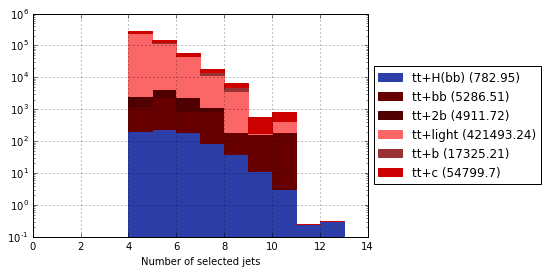

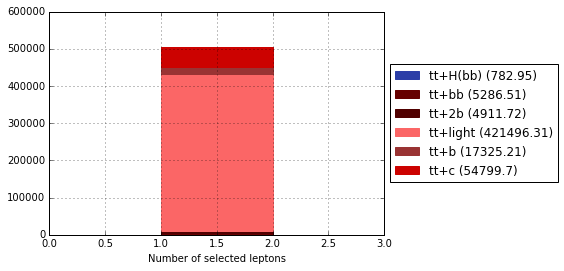

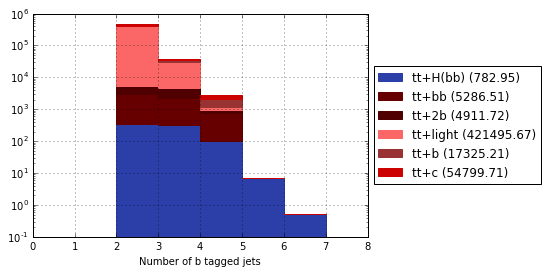

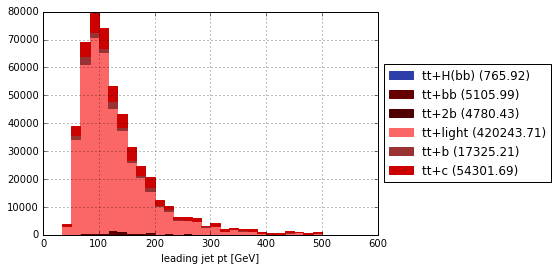

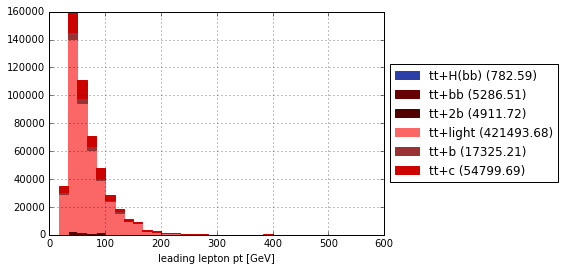

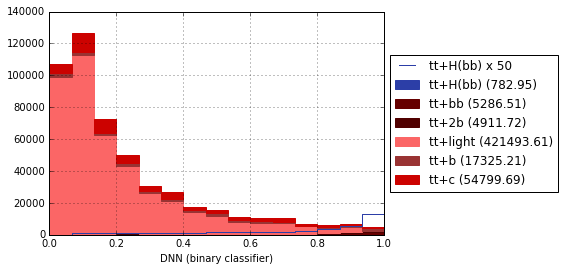

In [6]:
plot_histogram("njets", processes, data)
plot_histogram("nleps", processes, data)
plot_histogram("nbtags", processes, data)
plot_histogram("leading_jet_pt", processes, data)
plot_histogram("leading_lepton_pt", processes, data)
plot_histogram("DNN", processes, data)

# Calculation of stat. only result

In [51]:
def likelihood(mu, data_i, s_i, b_i):
    b_i[b_i < 0] = 0.0
    s_i[s_i < 0] = 0.0

    sel = ((s_i>0) & (b_i>0))
    
    ret = data_i[sel] * np.log(np.full(data_i.shape[0], mu)*s_i[sel] + b_i[sel]) - (mu*s_i[sel] + b_i[sel])
    return -np.sum(ret)

In [52]:
def make_fake_data(data, var, processes):
    
    # calculate total MC prediction
    for p in processes:
        if processes.index(p) == 0:
            counts = data["hist_" + p + "_" + var]["contents"]
        else:
            counts = [x + y for x, y in zip(counts, data["hist_" + p + "_" + var]["contents"])]
    
    return counts

In [76]:
def stat_fit(data, var, processes):
    
    fake_data = np.asarray(make_fake_data(data, var, processes))
    sig = np.asarray(data["hist_ttHTobb_" + var]["contents"])
    
    bkgs = [p for p in processes if p != "ttHTobb"]
    for p in bkgs:
        if bkgs.index(p) == 0:
            bkg_tot = data["hist_" + p + "_" + var]["contents"]
        else:
            bkg_tot = [x + y for x, y in zip(bkg_tot, data["hist_" + p + "_" + var]["contents"])]
    bkg_tot = np.asarray(bkg_tot)
    
    import scipy.optimize as optimize
    mu0 = 0.0
    res = optimize.minimize(likelihood, mu0, (fake_data, sig, bkg_tot), bounds = [(None,None)])

    # Error of estimator
    err = lambda mu: likelihood(mu, fake_data, sig, bkg_tot)-(likelihood(res.x, fake_data, sig, bkg_tot)+0.5)

    down = res.x - optimize.fsolve(err,(res.x - 3.0))[0]
    up = optimize.fsolve(err,(res.x + 0.01))[0] - res.x

    print "Best fit:", res.x[0], "-", down[0], "+", up[0]
    

In [77]:
stat_fit(data, "DNN", processes)

Best fit: 1.0 - 0.23961126426525747 + 0.24138978874951267
